# Deep Q-Learning for Atari Breakout

**Author:** [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20)<br>
**Date created:** 2020/05/23<br>
**Last modified:** 2020/06/17<br>
**Description:** Play Atari Breakout with a Deep Q-Network.

## Introduction

This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.

### Deep Q-Learning

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.

### Atari Breakout

In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.

### Note

The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.

### References

- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)

In [1]:
!pip install baselines

     |████████████████████████████████| 133kB 13.5MB/s 
     |████████████████████████████████| 1.4MB 23.9MB/s 
     |████████████████████████████████| 122kB 53.3MB/s 
     |████████████████████████████████| 215kB 55.9MB/s 
  Created wheel for baselines: filename=baselines-0.1.5-cp37-none-any.whl size=163903 sha256=c3963f9d0a41be8d4cf92394db53951e9fa83e406dc1d42cc4f440bdfa80974f
  Stored in directory: /root/.cache/pip/wheels/c3/95/d4/dc08613e714458fb368c44948025dade91a37db5932faa058f
  Created wheel for zmq: filename=zmq-0.0.0-cp37-none-any.whl size=1277 sha256=55981d1a9ec1416373a3bbd06e4fcd92dddf1c052f24ee46f7c46baaf2aedb88
  Stored in directory: /root/.cache/pip/wheels/44/7a/7d/ac1d865766b06f9769ac1154bf31dbb5abb3b52ecfe278247a
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065208 sha256=7798dc241971d509b234b06c44f68ef4165c6c84d925da3798f30af2398c92b7
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de5

## Setup

In [2]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
import csv
import random

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

[42, 742738649]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
save_length = 1

def csv_writer(file,data):
  
  if os.path.exists(file):
    file_name = file
  else:

    file = open(file, "x")
    file_name = file.name
  
  with open(file_name, mode='a') as buffer_file:
      buffer_memory = csv.writer(buffer_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      buffer_memory.writerow(data)

def csv_reader(file,counter=0):
  latest_buffer = []
  with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    rows = list(csv_reader)
    buffer_len = len(rows)
    if buffer_len > save_length:
      counter = 0
      row2 = rows
      row2 = row2 [-save_length:]
      with open(file, mode='w') as buffer_file:
        buffer_memory = csv.writer(buffer_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row1 in row2:
          buffer_memory.writerow(row1)
      latest_buffer = row2[-1]
    else:
        latest_buffer = rows[-1]
  
  return latest_buffer,counter

def make_directory(path):

  if os.path.exists(path):
        return
  else:
        os.mkdir(path)

make_directory("/content/drive/MyDrive/Spring 2021/ECE 6254 Stat Machine Learning/Project/data")
filepath_epsilon ="/content/drive/MyDrive/Spring 2021/ECE 6254 Stat Machine Learning/Project/data/epsilon.txt"

## Implement the Deep Q-Network

This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.

In [4]:
num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


def restore_model(path):
    model_total = [] 
    for saved_models in os.listdir(path):
      model_path = path + "/" + saved_models
      models = [model_path + "/" + name for name in os.listdir(model_path)]
      if models:
        latest_model = max(models,key= os.path.getctime)
        model_total.append(tf.keras.models.load_model(latest_model,compile = True))
      #else:
        #return "check filepath"
    return model_total

def make_video(frames,path,epsiode_count = 0):

  size = frames[0].shape # Size of each image in frame
  fps = 30
  out = cv2.VideoWriter(path + '/{}.mp4'.format(epsiode_count), cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0])) # Assumes RGB, need to only pass (width, height)
  
  for frame in frames:
      data = frame[:, :, ::-1] # assumes BGR format, so reverse channels
      out.write(data)
  
  out.release()

checkpoint_path = "/content/drive/MyDrive/Spring 2021/ECE 6254 Stat Machine Learning/Project/Models"
make_directory(checkpoint_path)
# make_directory(checkpoint_path + "/main_model")
# make_directory(checkpoint_path + "/target_model")
video_files = "/content/drive/MyDrive/Spring 2021/ECE 6254 Stat Machine Learning/Project/Videos"
make_directory(video_files)

loading_model = True
get_data = True
# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

if loading_model == True:
  models = restore_model(checkpoint_path)
  model = models[0]
  model_target = models[1]
#model.compile(optimizer = optimizer)
print(model.layers[1].get_weights())




[array([[[[-6.67697564e-02, -2.65157223e-02, -1.72974523e-02, ...,
           8.72208700e-02, -2.09328532e-02, -6.38142750e-02],
         [ 1.18071046e-02, -3.44365090e-02,  3.41732912e-02, ...,
           1.03795864e-01,  7.32204020e-02, -8.51616636e-02],
         [ 2.99622733e-02,  1.34727597e-01, -3.46653536e-02, ...,
           7.25227222e-02,  5.94091602e-02,  1.01454407e-02],
         [ 2.93245856e-02, -4.93384898e-02,  1.13895968e-01, ...,
           1.15213625e-01,  2.80930698e-02, -9.06297714e-02]],

        [[ 3.48544829e-02,  6.27174377e-02, -1.92447915e-04, ...,
          -6.19998947e-02,  4.71891090e-02, -1.92710668e-01],
         [-3.71250883e-02, -4.12728749e-02, -3.13159674e-02, ...,
          -1.49134785e-01,  4.50090878e-02, -3.69937681e-02],
         [ 3.39048877e-02,  6.83429986e-02,  1.61365103e-02, ...,
           3.23477499e-02, -2.27941703e-02,  7.42608011e-02],
         [-1.29224434e-01, -1.27325684e-01,  6.97506964e-02, ...,
           6.41193986e-02, -6.76601

In [5]:
env.reset()
path1 = video_files 
frame_count = 0
frames = []
done = False
for i in range(10000):
    if done:
      env.reset()
    frame_count += 1
    action = np.random.choice(num_actions)
    state_next, reward, done, _ = env.step(action) 
    
    if frame_count % 100 ==0:
      frames.append(env.render('rgb_array'))  #getting random actions based video
make_video(np.array(frames),path1)


10000
(100, 210, 160, 3)


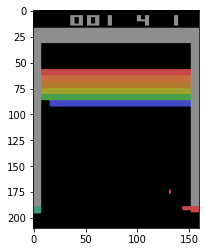

In [6]:
import matplotlib.pyplot as plt
#fig = plt.figure()
print(frame_count)
print(np.array(frames).shape)
path1 = video_files 
make_video(np.array(frames),path1,2)
plt.imshow(frames[80])
#plt.savefig(path1,dpi =fig.dpi)
plt.show()

## Train

In [ ]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
count_buffer = 0
count_epsilon = 0

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []


episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
#evaluate  after these episodes
eval_freq = 2000
#evaluation length
eval_length = 100000
#save frequency
save_freq = 2000
# Using huber loss for stability
loss_function = keras.losses.Huber()

all_rewards = []

if get_data == True:
  frame_count = epsilon_random_frames
  loaded_epsilon = csv_reader(filepath_epsilon)
  epsilon = float(loaded_epsilon[0][0])

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0
    total_lives = 5 # Number of lives per episode

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)
        

        # Apply the sampled action in our environment
        state_next, reward, done, info = env.step(action)
        lives_rem = info['ale.lives'] # Remaining lives
        live_diff = total_lives - info['ale.lives'] # Difference between current remaining lives and previous remaining

        if live_diff == 1: # Add a done in replay only
          replay_done = True
        else:
          replay_done = False

        total_lives = lives_rem # update remaining lives
        
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(replay_done)
        rewards_history.append(reward)
        state = state_next
        
        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break
    
    csv_writer(filepath_epsilon,[epsilon]) #write epsilons
    count_epsilon +=1
    if count_epsilon > save_length:
      _,counter = csv_reader(filepath_epsilon,count_buffer) #clipping the number of epsilons stored in csv file
      count_epsilon = counter
    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    all_rewards.append(episode_reward)

    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1
    if episode_count % save_freq == 0 and frame_count >= epsilon_random_frames:
        model.save(checkpoint_path + '/main_model' +"/{}".format(episode_count),include_optimizer=True)
        model_target.save(checkpoint_path + '/target_model' +"/{}".format(episode_count),include_optimizer= True )
        
    #evaluation
    if episode_count % eval_freq == 0 and frame_count >= epsilon_random_frames: #evaluating at a frequency
        print("hi")
        temp = episode_count/eval_freq
        video_path = video_files 
        episodes_visualized = 10
        done = True
        done_count = 0
        video_write = True
        evaluation_frame_count = 0
        eval_reward_sum = 0
        eval_rewards = []
        
        video_frame = []
        
        for i in range(eval_length): #at each evaluation, until the number of frames considered in evaluation
          
          if done:
            eval_state = np.array(env.reset())
            eval_state = np.array(eval_state)  #so the starting state is random
            done = False
          eval_state_tensor = tf.convert_to_tensor(eval_state)  
          eval_state_tensor = tf.expand_dims(eval_state_tensor, 0)  #input to the model, already preprocessed using wrapper functions by deepmind
          eval_action_probs = model(eval_state_tensor, training=False)
          eval_action = tf.argmax(eval_action_probs[0]).numpy() #get best action based on the model
          eval_state_next, eval_reward, done, _ = env.step(eval_action) #get the next state
          eval_state_next = np.array(eval_state_next)
          eval_state = eval_state_next  #update state to the next_state
          evaluation_frame_count += 1
          eval_reward_sum += eval_reward 
          if video_write:
            video_frame.append(np.array(env.render('rgb_array'))) #image of current environment
          if done:
            eval_rewards.append(eval_reward_sum)
            done_count +=1
          if done_count == episodes_visualized: #number of episodes in the video
            video_write = False
        make_video(np.array(video_frame),video_path,episode_count)

    print("Reward at episode {}: {}".format(episode_count, episode_reward))

    if running_reward > 40:  # Condition to consider the task solved
      print("Solved at episode {}!".format(episode_count))
      break



  
          
            


Streaming output truncated to the last 5000 lines.
Reward at episode 1665: 2.0
Reward at episode 1666: 6.0
Reward at episode 1667: 4.0
Reward at episode 1668: 5.0
Reward at episode 1669: 3.0
Reward at episode 1670: 3.0
Reward at episode 1671: 37.0
Reward at episode 1672: 12.0
Reward at episode 1673: 13.0
Reward at episode 1674: 4.0
Reward at episode 1675: 4.0
Reward at episode 1676: 5.0
Reward at episode 1677: 20.0
Reward at episode 1678: 16.0
Reward at episode 1679: 5.0
Reward at episode 1680: 7.0
Reward at episode 1681: 2.0
Reward at episode 1682: 15.0
Reward at episode 1683: 12.0
running reward: 8.32 at episode 1683, frame count 430000
Reward at episode 1684: 11.0
Reward at episode 1685: 1.0
Reward at episode 1686: 1.0
Reward at episode 1687: 6.0
Reward at episode 1688: 21.0
Reward at episode 1689: 3.0
Reward at episode 1690: 2.0
Reward at episode 1691: 2.0
Reward at episode 1692: 23.0
Reward at episode 1693: 5.0
Reward at episode 1694: 7.0
Reward at episode 1695: 1.0
Reward at epis

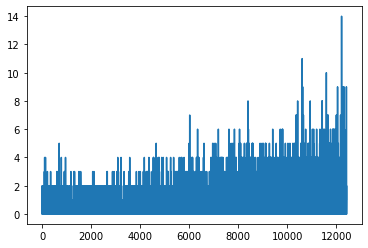

## Visualizations
Before any training:
![Imgur](https://i.imgur.com/rRxXF4H.gif)

In early stages of training:
![Imgur](https://i.imgur.com/X8ghdpL.gif)

In later stages of training:
![Imgur](https://i.imgur.com/Z1K6qBQ.gif)

# New Section